## Import

In [1]:
%matplotlib inline
import matplotlib
import random
import wget
import os
import pathlib
import torch
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from enum import Enum
from tqdm import tqdm
from functools import partial
from shutil import rmtree
from datasets import load_metric, Dataset, DatasetDict
from razdel import tokenize
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from torch.optim import AdamW
from torch.utils.data import random_split, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, BertTokenizer, AutoModelForMaskedLM, BertForSequenceClassification, \
                         get_linear_schedule_with_warmup, AutoModel, AutoModelForCausalLM, DataCollatorForSeq2Seq, \
                         Seq2SeqTrainingArguments, Seq2SeqTrainer, T5Tokenizer, T5ForConditionalGeneration

tqdm.pandas()

print('Import is done.')

C:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import is done.


## Configuration

In [2]:
class Configurator:
    def __init__(self) -> None:
        self._params = {
            'random.seed': 42,
            
            'url.dataset.train': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_train.csv?raw=true',
            'url.dataset.test': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_dev.csv?raw=true',
            
            'path.dataset.train': './train_dataset.csv',
            'path.dataset.test': './test_dataset.csv',
            
            'name.train': 'TRAIN',
            'name.test': 'TEST',
  
            'dataframe.train.names': ['id', 'sentence', 'acceptable', 'error_type', 'detailed_source'],
            'dataframe.test.names': ['id', 'sentence', 'acceptable', 'error_type', 'detailed_source'],
            
            'bert.train-size': 0.9,
            'bert.batch-size': 32,
            'bert.optimizer.learning-rate': 2e-5,
            'bert.optimizer.eps': 1e-8,
#             'bert.train.epochs': 2
            'bert.train.epochs': 1,
            'bert.pretrain.path': 'ai-forever/ruBert-base',
#             'bert.pretrain.path': 'DeepPavlov/rubert-base-cased',
            
            'gpt.pretrain.path': 'ai-forever/rugpt3large_based_on_gpt2',
            
            't5.model-name': 't5-base',
            't5.pretrain.path': 'ai-forever/ruT5-base',
            't5.n-seeds': 1,
            't5.n-epochs': 20,
            't5.lr-values': (1e-4, 1e-3),
            't5.decay-vales': (0, 1e-4),
            't5.batch-sizes': (128,),
            't5.label.pos': 'yes',
            't5.label.neg': 'no',
            't5.dataset.url.train': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_train.csv?raw=true',
            't5.dataset.url.in-domain-dev': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/in_domain_dev.csv?raw=true',
            't5.dataset.url.out-of-domain-dev': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/out_of_domain_dev.csv?raw=true',
            't5.dataset.url.test': 'https://github.com/RussianNLP/RuCoLA/blob/main/data/test.csv?raw=true',
            't5.dataset.path.train': './data/in_domain_train.csv',
            't5.dataset.path.in-domain-dev': './data/in_domain_dev.csv',
            't5.dataset.path.out-of-domain-dev': './data/out_of_domain_dev.csv',
            't5.dataset.path.test': './data/test.csv',
            't5.const-training-args': {
                'overwrite_output_dir': True,
                'evaluation_strategy': 'epoch',
                'lr_scheduler_type': 'constant',
                'save_strategy': 'epoch',
                'save_total_limit': 1,
                'fp16': True,
                'dataloader_num_workers': 4,
                'group_by_length': True,
                'report_to': 'none',
                'load_best_model_at_end': True,
                'metric_for_best_model': 'eval_mcc',
                'optim': 'adafactor',
                'predict_with_generate': True
            }
        }
    
    def __call__(self, *args, **kwargs):
        if len(args) == 0 or args[0] not in self._params:
            return None
        return self._params[args[0]]
    
    def check(self, *args):
        result = True
        absence_params = set()
        for arg in args:
            if isinstance(arg, str) and arg not in self._params:
                result = False
                absence_params.add(arg)
        message = 'Absence params: ' + ', '.join(absence_params)
        assert result, message
        
        
conf = Configurator()

print('Configuration block is done.')

Configuration block is done.


## Conditions

In [3]:
class CList(Enum):
    SET_RANDOM_SEED = 0
    DEVICE_DEFINED = 1
    DATASET_DOWNLOADED = 2
    DATASET_LOADED = 3
    DATASET_PREPARED = 4
    TOKENIZERS_MODELS_CREATED = 5
    BERT_SCHEDULER_CREATED = 6
    BERT_TRAINED = 7
    BERT_TESTED = 8
    GPT_PREPARED = 9

class Conditions:    
    def __init__(self) -> None:
        self._conditions = {}
        
    def set(self, message, *conditions):
        for condition in conditions:
            self._conditions[condition] = True
        print(message)
    
    def check(self, *conditions):
        result = True
        absence = set()
        for condition in conditions:
            if condition not in self._conditions:
                result = False
                absence.add(condition.name)
        fail_message = 'Absence conditions: ' + ', '.join(absence)
        assert result, fail_message

conds = Conditions()

print('Conditions block is done.')

Conditions block is done.


## Set random seed

In [4]:
conf.check('random.seed')

random.seed(conf('random.seed'))
np.random.seed(conf('random.seed'))
torch.manual_seed(conf('random.seed'))
torch.cuda.manual_seed(conf('random.seed'))

conds.set('Random seed is set.', CList.SET_RANDOM_SEED)

Random seed is set.


## Define device

In [5]:
conds.check(CList.SET_RANDOM_SEED)

if torch.cuda.is_available():
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
    device = torch.device('cuda')
else:
    print('No GPU available, using the GPU instead.')
    device = torch.device('cpu')
    
conds.set("Device is defined", CList.DEVICE_DEFINED)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Device is defined


## Models & tokenizers & optimizers creation

In [6]:
conf.check('bert.optimizer.learning-rate', 'bert.optimizer.eps', 'bert.pretrain.path', 'gpt.pretrain.path')
conds.check(CList.DEVICE_DEFINED)

bert_tokenizer = BertTokenizer.from_pretrained(conf('bert.pretrain.path'))
bert_model = BertForSequenceClassification.from_pretrained(
    conf('bert.pretrain.path'),
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
bert_optimizer = AdamW(bert_model.parameters(), lr=conf('bert.optimizer.learning-rate'), eps=conf('bert.optimizer.eps'))

gpt_tokenizer = AutoTokenizer.from_pretrained(conf('gpt.pretrain.path'))
gpt_model = AutoModelForCausalLM.from_pretrained(conf('gpt.pretrain.path'))

conds.set('Models & tokenizers creation is done.', CList.TOKENIZERS_MODELS_CREATED)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Models & tokenizers creation is done.


## Downloading datasets on disk

In [7]:
# optimize checking  !!!
conf.check(
    'url.dataset.train',
    'path.dataset.train',
    'name.train',
    'url.dataset.test',
    'path.dataset.test',
    'name.test'
);
conds.check(CList.TOKENIZERS_MODELS_CREATED)

def load_dataset(url: str, path: str, name: str):
    if os.path.exists(path):
        print('Dataset "' + name + '" is already downloaded.')
    else:
        wget.download(url, path)
        print(' Dataset "' + name + '" is downloaded.')
        
load_dataset(conf('url.dataset.train'), conf('path.dataset.train'), conf('name.train'))
load_dataset(conf('url.dataset.test'), conf('path.dataset.test'), conf('name.test'))
conds.set('Datasets downloading is done', CList.DATASET_DOWNLOADED)

Dataset "TRAIN" is already downloaded.
Dataset "TEST" is already downloaded.
Datasets downloading is done


## Loading datasets from disk

In [8]:
conf.check(
    'path.dataset.train',
    'path.dataset.test',
    'dataframe.train.names',
    'dataframe.test.names'
)
conds.check(CList.DATASET_DOWNLOADED)

train_dataframe = pd.read_csv(
    conf('path.dataset.train'),
    names=conf('dataframe.train.names'),
    skiprows=1,
    usecols=conf('dataframe.train.usecols')
)

test_dataframe = pd.read_csv(
    conf('path.dataset.test'),
    names=conf('dataframe.test.names'),
    skiprows=1,
    usecols=conf('dataframe.test.usecols')
)
conds.set('Datasets are loaded from disk.', CList.DATASET_LOADED)

Datasets are loaded from disk.


## BERT datasets preparation, create dataloaders

In [9]:
conf.check('bert.batch-size', 'bert.batch-size', 'bert.batch-size')
conds.check(CList.DATASET_LOADED)

train_sentences = train_dataframe.sentence.values
train_acceptables = train_dataframe.acceptable.values
test_sentences = test_dataframe.sentence.values
test_acceptables = test_dataframe.acceptable.values


def define_raw_max_length_by_bert(sentences, raw_max_length):
    for sentence in sentences:
        input_ids = bert_tokenizer.encode(sentence, add_special_tokens=True)
        raw_max_length = max(raw_max_length, len(input_ids))    
    return raw_max_length


raw_max_length = define_raw_max_length_by_bert(train_sentences, 0)
raw_max_length = define_raw_max_length_by_bert(test_sentences, raw_max_length)


def define_max_length(raw_max_length, threshold):
    return threshold if threshold >= raw_max_length else define_max_length(raw_max_length, threshold * 2)


max_length = define_max_length(raw_max_length, 1)

def create_bert_dataset(sentences, acceptables, max_length):
    input_ids = []
    attention_masks = []
    for sentence in sentences:
        encoded_dict = bert_tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    acceptables = torch.tensor(acceptables)

    return TensorDataset(input_ids, attention_masks, acceptables)

train_val_dataset = create_bert_dataset(train_sentences, train_acceptables, max_length)
test_dataset = create_bert_dataset(test_sentences, test_acceptables, max_length);

train_val_dataset_size = len(train_val_dataset)
train_size = int(conf('bert.train-size') * train_val_dataset_size)
val_size = train_val_dataset_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=conf('bert.batch-size'))
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=conf('bert.batch-size'))
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=conf('bert.batch-size'))

conds.set('BERT datasets are prepared.', CList.DATASET_PREPARED)

BERT datasets are prepared.


## BERT scheduler creation

In [10]:
conf.check('bert.train.epochs')
conds.check(CList.DATASET_PREPARED)

bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * conf('bert.train.epochs')
)

conds.set('BERT scheduler is created.', CList.BERT_SCHEDULER_CREATED)

BERT scheduler is created.


## BERT finetune training


======= Epoch 1 / 1 =======

Training...
	Batch 40 of 222, elapsed: 0:00:10
	Batch 80 of 222, elapsed: 0:00:18
	Batch 120 of 222, elapsed: 0:00:26
	Batch 160 of 222, elapsed: 0:00:34
	Batch 200 of 222, elapsed: 0:00:42
	Batch 222 of 222, elapsed: 0:00:47

	Average training loss: 0.5317554961856421
	Training epcoh took: 0:00:47

Running validation...

	Accuracy: 0.7707894736842106
	Validation loss: 0.5111633718013764
	Validation took: 0:00:01

Trainig complete!
Total trainig took: 0:00:48


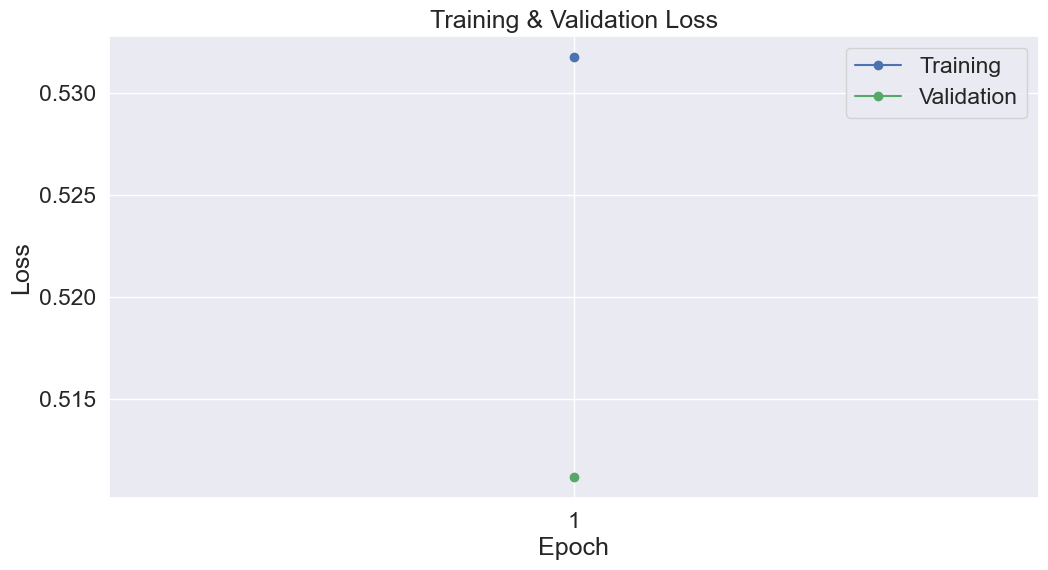

BERT is trained.


In [11]:
conf.check('bert.train.epochs')
conds.check(CList.BERT_SCHEDULER_CREATED)

# < !!! to utils block & rename
def flat_accuracy_bert(predictions, labels):
    predictions_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(predictions_flat == labels_flat) / len(labels_flat)

# < !!! to utils block & rename
def format_time_bert(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

# < !!!
def log_step(step: int, offset: int, length: int, t0):
    if ((step + 1) % offset == 0 and not step == 0) or (step == length - 1):
        elapsed = format_time_bert(time.time() - t0)
        print(f'\tBatch {step+1} of {len(train_dataloader)}, elapsed: {elapsed}')    

# < !!!
def extract_from_batch(batch, device) -> tuple:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    return b_input_ids, b_input_mask, b_labels

bert_model.cuda()

training_stats = []
total_t0 = time.time()
train_dataloader_length = len(train_dataloader)
val_dataloader_length = len(val_dataloader)

epochs = conf('bert.train.epochs')
for epoch_i in range(0, epochs):
    print(f'\n======= Epoch {epoch_i + 1} / {epochs} =======\n')
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    bert_model.train()
        
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)
        bert_model.zero_grad()
        
        res = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = res['loss']

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        bert_optimizer.step()
        bert_scheduler.step()
        
        log_step(step, 40, train_dataloader_length, t0)
    
    avg_train_loss = total_train_loss / train_dataloader_length
    train_time = format_time_bert(time.time() - t0)
    print(f'\n\tAverage training loss: {avg_train_loss}\n\tTraining epcoh took: {train_time}')

    print('\nRunning validation...')
    t0 = time.time()
    total_eval_accuracy = 0
    total_eval_loss = 0
    
    bert_model.eval()
    
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)
        
        with torch.no_grad():
            res = bert_model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        loss = res['loss']
        logits = res['logits']
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy_bert(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / val_dataloader_length
    avg_val_loss = total_eval_loss / val_dataloader_length
    val_time = format_time_bert(time.time() - t0)
    print(f'\n\tAccuracy: {avg_val_accuracy}')
    print(f'\tValidation loss: {avg_val_loss}')
    print(f'\tValidation took: {val_time}')
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': train_time,
            'Validation Time': val_time
        }
    )

print('\nTrainig complete!')
print(f'Total trainig took: {format_time_bert(time.time() - total_t0)}')

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i + 1 for i in range(epochs)])

plt.show()

conds.set('BERT is trained.', CList.BERT_TRAINED)

## BERT test & MCC calculation

In [12]:
conds.check(CList.BERT_SCHEDULER_CREATED)

# < !!!
def extract_from_batch(batch, device) -> tuple:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    return b_input_ids, b_input_mask, b_labels

bert_model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = extract_from_batch(batch, device)

    with torch.no_grad():
        outputs = bert_model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('Positive samples: %d of %d (%.2f%%)' % (test_dataframe.acceptable.sum(), len(test_dataframe.acceptable), (test_dataframe.acceptable.sum() / len(test_dataframe.acceptable) * 100.0)))

matthews_set = []
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

conds.set('BERT is tested.', CList.BERT_TESTED)

Positive samples: 733 of 983 (74.57%)
Total MCC: 0.258
BERT is tested.


## GPT preparation

In [17]:
conds.check(CList.TOKENIZERS_MODELS_CREATED)

def calc_gpt_loss(text):
    inputs = gpt_tokenizer.encode(text, return_tensors='pt').reshape(-1).to(device)
    with torch.no_grad():
        loss = gpt_model(input_ids=inputs, labels=inputs).loss.item()
    return loss

def shot_gpt(begin: str, text: str, positive_statement: str, negative_statement: str):
    positive_loss = calc_gpt_loss(' '.join([begin, text, positive_statement]))
    negative_loss = calc_gpt_loss(' '.join([begin, text, negative_statement]))

    return 1 if positive_loss > negative_loss else 0

gpt_model.to(device)

conds.set('GPT preparation is done.', CList.GPT_PREPARED)

GPT preparation is done.


## Zero shot

In [18]:
conds.check(CList.GPT_PREPARED)

tasks = [
    {
        'begin': 'Если ли здесь ошибка?',
        'positive_statement': 'Предложение правильное.',
        'negative_statement': 'Допущена ошибка.'
    },
    {
        'begin': 'Если ли здесь ошибка?',
        'positive_statement': 'Нет.',
        'negative_statement': 'Есть.'
    },
    {
        'begin': 'Если ли здесь ошибка?',
        'positive_statement': 'Отсутствует.',
        'negative_statement': 'Присутствует.'
    },
    {
        'begin': 'Проверь на ошибки.',
        'positive_statement': 'Нет',
        'negative_statement': 'Есть.'
    },
    {
        'begin': 'Проверь на ошибки.',
        'positive_statement': 'Отсутствуют.',
        'negative_statement': 'Присутствуют.'
    }
]

# use and mcc and f1
# < find best

for task in tasks:
    progress_function = lambda text: shot_gpt(task['begin'], text, task['positive_statement'], task['negative_statement'])
    y_pred = test_dataframe['sentence'].progress_apply(progress_function)
    print(f'Begin: {task["begin"]}, positive_statement: {task["positive_statement"]}, negative_statement: {task["negative_statement"]}')
    print(f'F1-score: {f1_score(y_pred, test_dataframe["acceptable"])}')


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:44<00:00, 21.88it/s]


Begin: Если ли здесь ошибка?, positive_statement: Предложение правильное., negative_statement: Допущена ошибка.
F1-score: 0.8543123543123543


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:44<00:00, 22.16it/s]


Begin: Если ли здесь ошибка?, positive_statement: Нет., negative_statement: Есть.
F1-score: 0.01349527665317139


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:44<00:00, 22.16it/s]


Begin: Если ли здесь ошибка?, positive_statement: Отсутствует., negative_statement: Присутствует.
F1-score: 0.13184079601990048


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:44<00:00, 22.15it/s]


Begin: Проверь на ошибки., positive_statement: Нет, negative_statement: Есть.
F1-score: 0.14390243902439026


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:45<00:00, 21.48it/s]

Begin: Проверь на ошибки., positive_statement: Отсутствуют., negative_statement: Присутствуют.
F1-score: 0.19437939110070257


## Few shot (3)

In [19]:
conds.check(CList.GPT_PREPARED)

promt = """Проверить корректность предложения:
Иван вчера не позвонил. => Верно
Лесные запахи набегали волнами; в них смешалось дыхание можжевельника, вереска, брусники. => Верно
У многих туристов, кто посещают Кемер весной, есть шанс застать снег на вершине горы Тахталы и даже сочетать пляжный отдых с горнолыжным. => Неверно
"""

y_pred = test_dataframe['sentence'].progress_apply(lambda text: shot_gpt(promt, text, ' => Верно', ' => Неверно'))
print(f'F1-score: {f1_score(y_pred, test_dataframe["acceptable"])}')


100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [01:10<00:00, 14.02it/s]

F1-score: 0.8543123543123543


## Few shot (5)

In [20]:
conds.check(CList.GPT_PREPARED)

promt = """Проверить корректность предложения:
Вчера президент имел неофициальную беседу с английским послом. => Верно
А ты ехай прямо к директору театров, князю Гагарину. => Неверно
Коллега так и не признал вину за катастрофу перед коллективом. => Верно
Малыш уже уверенно читает слова через мягкий знак. => Неверно
Я говорил с ним только ради Вас. => Верно
"""

y_pred = test_dataframe['sentence'].progress_apply(lambda text: shot_gpt(promt, text, ' => Верно', ' => Неверно'))
print(f'F1-score: {f1_score(y_pred, test_dataframe["acceptable"])}')

100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [01:11<00:00, 13.69it/s]

F1-score: 0.8543123543123543


## Few shot (10)

In [21]:
conds.check(CList.GPT_PREPARED)

promt = """Проверить корректность предложения:
Только бы он громко не закричал, когда найдет решение. => Верно
Но Коле не помог его иноверец. => Неверно
Гармоничные пропорции здания основаны на классических образцах. => Верно
Вчера мне нужно ехать на завод. => Неверно
Дело приняло дурной оборот. => Верно
Я стою поблизости от Центризбиркома и наблюдаю за тем, что происходит у входа. => Неверно
Вани не было в школе. => Верно
В качестве примеров были приведены случаи, о которых, кажется, что где-то я уже читал. => Неверно
Кожа у виска была желтой. => Верно
В эту минуту роман был прочитан. => Неверно
"""

y_pred = test_dataframe['sentence'].progress_apply(lambda text: shot_gpt(promt, text, ' => Верно', ' => Неверно'))
print(f'F1-score: {f1_score(y_pred, test_dataframe["acceptable"])}')

100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [01:47<00:00,  9.12it/s]

F1-score: 0.8543123543123543


## T5

In [13]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

ACCURACY = load_metric('accuracy', keep_in_memory=True)
MCC = load_metric('matthews_correlation', keep_in_memory=True)

def check_or_create_directory(path: Path) -> None:
    if not os.path.isdir(path):
        pathlib.Path.mkdir(pathlib.Path(path))


def load_dataset(url: str, file_path: Path) -> None:
    file_path = str(file_path)
    if os.path.exists(file_path):
        print(f' Dataset {file_path} is already downloaded.')
    else:
        wget.download(url, file_path)
        print(f' Dataset {file_path} is downloaded.')


def read_splits():    
    train_df, in_domain_dev_df, out_of_domain_dev_df, test_df = map(
        pd.read_csv,
        (
            conf('t5.dataset.path.train'),
            conf('t5.dataset.path.in-domain-dev'),
            conf('t5.dataset.path.out-of-domain-dev'),
            conf('t5.dataset.path.test')
        )
    )

    # concatenate datasets to get aggregate metrics
    dev_df = pd.concat((in_domain_dev_df, out_of_domain_dev_df))

    train, dev, test = map(Dataset.from_pandas, (train_df, dev_df, test_df))
    return DatasetDict(train=train, dev=dev, test=test)


def compute_metrics(p, tokenizer):
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if prediction == conf('t5.label.pos') else 0 for prediction in string_preds]

    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    int_labels = []

    for string_label in string_labels:
        if string_label == conf('t5.label.pos'):
            int_labels.append(1)
        elif string_label == conf('t5.label.neg') or string_label == '': # second case accounts for test data
            int_labels.append(0)
        else:
            raise ValueError()

    acc_result = ACCURACY.compute(predictions=int_preds, references=int_labels)
    mcc_result = MCC.compute(predictions=int_preds, references=int_labels)

    result = {'accuracy': acc_result['accuracy'], 'mcc': mcc_result['matthews_correlation']}
    return result


def preprocess_examples(examples, tokenizer):
    result = tokenizer(examples['sentence'], padding=True)

    if 'acceptable' in examples:
        label_sequences = []
        for label in examples['acceptable']:
            if label == 1:
                target_sequence = conf('t5.label.pos')
            elif label == 0:
                target_sequence = conf('t5.label.pos')
            else:
                raise ValueError('Unknown class label')
            label_sequences.append(target_sequence)
    else:
        label_sequences = ['' for _ in examples['sentence']]

    result['labels'] = tokenizer(label_sequences, padding=False)['input_ids']
    result['length'] = [len(list(tokenize(sequence))) for sequence in examples['sentence']]

    return result


def create_training_args(run_base_dir,
                         batch_size,
                         learning_rate,
                         weight_decay,
                         seed):
    return Seq2SeqTrainingArguments(
        output_dir=f'checkpoints/{run_base_dir}',
        overwrite_output_dir=conf('t5.const-training-args')['overwrite_output_dir'],
        evaluation_strategy=conf('t5.const-training-args')['evaluation_strategy'],
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=conf('t5.n-epochs'),
        lr_scheduler_type=conf('t5.const-training-args')['lr_scheduler_type'],
        save_strategy=conf('t5.const-training-args')['save_strategy'],
        save_total_limit=conf('t5.const-training-args')['save_total_limit'],
        seed=seed,
        fp16=conf('t5.const-training-args')['fp16'],
        dataloader_num_workers=conf('t5.const-training-args')['dataloader_num_workers'],
        group_by_length=conf('t5.const-training-args')['group_by_length'],
        report_to=conf('t5.const-training-args')['report_to'],
        load_best_model_at_end=conf('t5.const-training-args')['load_best_model_at_end'],
        metric_for_best_model=conf('t5.const-training-args')['metric_for_best_model'],
        optim=conf('t5.const-training-args')['optim'],
        predict_with_generate=conf('t5.const-training-args')['predict_with_generate']
    )


check_or_create_directory('./data')

load_dataset(conf('t5.dataset.url.train'), conf('t5.dataset.path.train'))
load_dataset(conf('t5.dataset.url.in-domain-dev'), conf('t5.dataset.path.in-domain-dev'))
load_dataset(conf('t5.dataset.url.out-of-domain-dev'), conf('t5.dataset.path.out-of-domain-dev'))
load_dataset(conf('t5.dataset.url.test'), conf('t5.dataset.path.test'))

tokenizer = T5Tokenizer.from_pretrained(conf('t5.pretrain.path'))
splits = read_splits()

tokenized_splits = splits.map(
    partial(preprocess_examples, tokenizer=tokenizer),
    batched=True,
    remove_columns=['sentence']
)

data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8)
dev_metrics_per_run = np.empty((
    conf('t5.n-seeds'),
    len(conf('t5.lr-values')),
    len(conf('t5.decay-vales')),
    len(conf('t5.batch-sizes')),
    2
))

for i, learning_rate in enumerate(conf('t5.lr-values')):
    for j, weight_decay in enumerate(conf('t5.decay-vales')):
        for k, batch_size in enumerate(conf('t5.batch-sizes')):
            for seed in range(conf('t5.n-seeds')):
                model = T5ForConditionalGeneration.from_pretrained(conf('t5.pretrain.path'))
                model.to(device)
                run_base_dir = f'{conf("t5.model-name")}_{learning_rate}_{weight_decay}_{batch_size}'

                training_args = create_training_args(run_base_dir, batch_size, learning_rate, weight_decay, seed)
                trainer = Seq2SeqTrainer(
                    model=model,
                    args=training_args,
                    train_dataset=tokenized_splits['train'],
                    eval_dataset=tokenized_splits['dev'],
                    compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
                    tokenizer=tokenizer,
                    data_collator=data_collator
                )

                train_result = trainer.train()
                print(f'{run_base_dir}_{seed}')
                print(f'train {train_result.metrics}')

                os.makedirs(f'results/{run_base_dir}_{seed}', exist_ok=True)

                dev_predictions = trainer.predict(
                    test_dataset=tokenized_splits['dev'],
                    metric_key_prefix='test',
                    max_length=10
                )
                print(f'dev {dev_predictions.metrics}')
                dev_metrics_per_run[seed, i, j, k] = (
                    dev_predictions.metrics['test_accuracy'],
                    dev_predictions.metrics['test_mcc']
                )

                predictions = trainer.predict(test_dataset=tokenized_splits['test'], max_length=10)
                string_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

                int_preds = [1 if prediction == conf('t5.label.pos') else 0 for prediction in string_preds]
                int_preds = np.asarray(int_preds)

                np.save(f'results/{run_base_dir}_{seed}/preds.npy', int_preds)
                rmtree(f'checkpoints/{run_base_dir}')

os.makedirs('result_agg', exist_ok=True)
np.save(f'result_agg/{conf("t5.model-name")}_dev.npy', dev_metrics_per_run)

C:\Users\KasymbekovPN\AppData\Local\Temp\ipykernel_11696\1797478514.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  ACCURACY = load_metric('accuracy', keep_in_memory=True)


 Dataset ./data/in_domain_train.csv is already downloaded.
 Dataset ./data/in_domain_dev.csv is already downloaded.
 Dataset ./data/out_of_domain_dev.csv is already downloaded.
 Dataset ./data/test.csv is already downloaded.


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
C:\Python310\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot locate reference to <class 'razdel.segmenters.tokenize.TokenSegmenter'>.
  StockPickler.save(self, obj, save_persistent_id)
C:\Python310\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot pickle <class 'razdel.segmenters.tokenize.TokenSegmenter'>: razdel.segmenters.tokenize.TokenSegmenter has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Map: 100%|████████████████████████████████████████████████████████████████| 2789/2789 [00:00<00:00, 6549.53 examples/s]


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.000000,1.000000,0.000000
2,No log,0.000000,1.000000,0.000000
3,No log,0.000000,1.000000,0.000000
4,No log,0.000000,1.000000,0.000000
5,No log,0.000000,1.000000,0.000000
6,No log,0.000000,1.000000,0.000000
7,No log,0.000000,1.000000,0.000000
8,No log,0.000000,1.000000,0.000000
9,0.182000,0.000000,1.000000,0.000000
10,0.182000,0.000000,1.000000,0.000000


t5-base_0.0001_0_128_0
train {'train_runtime': 13249.8882, 'train_samples_per_second': 11.878, 'train_steps_per_second': 0.094, 'total_flos': 8984793076531200.0, 'train_loss': 0.07336962467795216, 'epoch': 20.0}


dev {'test_loss': 2.9456572292474448e-08, 'test_accuracy': 1.0, 'test_mcc': 0.0, 'test_runtime': 95.0673, 'test_samples_per_second': 29.316, 'test_steps_per_second': 0.231}


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.000000,1.000000,0.000000
2,No log,0.000000,1.000000,0.000000
3,No log,0.000000,1.000000,0.000000
4,No log,0.000000,1.000000,0.000000
5,No log,0.000000,1.000000,0.000000
6,No log,0.000000,1.000000,0.000000
7,No log,0.000000,1.000000,0.000000
8,No log,0.000000,1.000000,0.000000
9,0.182000,0.000000,1.000000,0.000000
10,0.182000,0.000000,1.000000,0.000000


t5-base_0.0001_0.0001_128_0
train {'train_runtime': 14032.2476, 'train_samples_per_second': 11.216, 'train_steps_per_second': 0.088, 'total_flos': 8984793076531200.0, 'train_loss': 0.07336962467795216, 'epoch': 20.0}


dev {'test_loss': 2.9456572292474448e-08, 'test_accuracy': 1.0, 'test_mcc': 0.0, 'test_runtime': 139.6134, 'test_samples_per_second': 19.962, 'test_steps_per_second': 0.158}


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.000000,1.000000,0.000000
2,No log,0.000000,1.000000,0.000000
3,No log,0.000000,1.000000,0.000000
4,No log,0.000000,1.000000,0.000000
5,No log,0.000000,1.000000,0.000000
6,No log,0.000000,1.000000,0.000000
7,No log,0.000000,1.000000,0.000000
8,No log,0.000000,1.000000,0.000000
9,0.225800,0.000000,1.000000,0.000000
10,0.225800,0.000000,1.000000,0.000000


t5-base_0.001_0_128_0
train {'train_runtime': 15946.0479, 'train_samples_per_second': 9.87, 'train_steps_per_second': 0.078, 'total_flos': 8984793076531200.0, 'train_loss': 0.09103632387304213, 'epoch': 20.0}


dev {'test_loss': 0.0, 'test_accuracy': 1.0, 'test_mcc': 0.0, 'test_runtime': 66.4812, 'test_samples_per_second': 41.922, 'test_steps_per_second': 0.331}


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.000000,1.000000,0.000000
2,No log,0.000000,1.000000,0.000000
3,No log,0.000000,1.000000,0.000000
4,No log,0.000000,1.000000,0.000000
5,No log,0.000000,1.000000,0.000000
6,No log,0.000000,1.000000,0.000000
7,No log,0.000000,1.000000,0.000000
8,No log,0.000000,1.000000,0.000000
9,0.236100,0.000000,1.000000,0.000000
10,0.236100,0.000000,1.000000,0.000000


t5-base_0.001_0.0001_128_0
train {'train_runtime': 5281.5862, 'train_samples_per_second': 29.798, 'train_steps_per_second': 0.235, 'total_flos': 8984793076531200.0, 'train_loss': 0.09520592424701428, 'epoch': 20.0}


dev {'test_loss': 0.0, 'test_accuracy': 1.0, 'test_mcc': 0.0, 'test_runtime': 57.6061, 'test_samples_per_second': 48.38, 'test_steps_per_second': 0.382}
